In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn import linear_model
import scipy.stats as stat

In [2]:
# Read in and store the daily tally of flights, delete each time as kernel dies with large files
day_tally = pd.DataFrame()
for file in os.listdir('archive (1)/'):
    day = pd.read_csv(f'archive (1)/{file}')
    day['FL_DATE'] = pd.to_datetime(day['FL_DATE'], dayfirst=True)
    total = pd.DataFrame(day['FL_DATE'].value_counts().sort_index())
    del(day)
    day_tally = pd.concat([day_tally,total])

In [4]:
# Read in and store the number of cancellations of flights, delete each time as kernel dies with large files
data = pd.DataFrame()
for file in os.listdir('archive (1)/'):
    data_2015 = pd.read_csv(f'archive (1)/{file}')
    data_2015['FL_DATE'] = pd.to_datetime(data_2015['FL_DATE'], dayfirst=True)
    data_2015 = data_2015.loc[data_2015['CANCELLED'] == 1]
    freq_2015 = pd.DataFrame(data_2015['FL_DATE'].value_counts().sort_index())
    del(data_2015)
    data = pd.concat([data,freq_2015])

In [26]:
# Sort the data to ensure correct time series
data = data.sort_index()

# Calculate 3 standard deviations away from the mean and remove outliers
np.mean(data['FL_DATE'] ) + 3*np.sqrt(np.var(data['FL_DATE'] ))
data = data[data['FL_DATE'] < 1500] 

1530.3466582991055

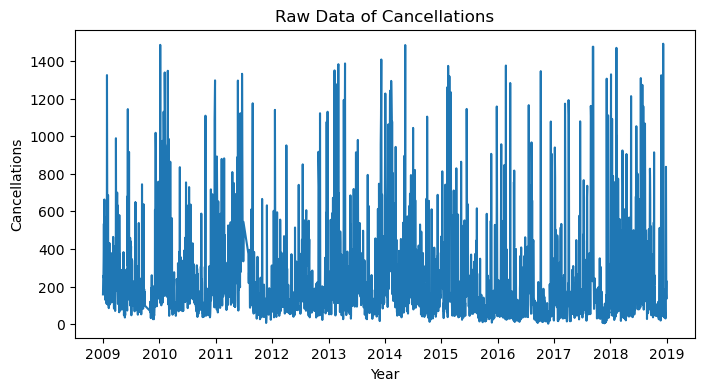

In [28]:
freq = data['FL_DATE']

# Plot the raw data (outliers removed)
plt.figure(figsize=(8,4))
plt.ylabel("Cancellations")
plt.xlabel("Year") 
plt.plot(data.index, freq)
plt.title('Raw Data of Cancellations') 
plt.savefig('raw_data.png')

In [29]:
# boxcar smoothing
def boxcar(x , n):
    window = range(-n,n+1)
    data_range = range(n,len(x)-n)
    smooth_x = []
    for i in data_range:
        smooth_x.append(0)
        for j in window:
            smooth_x[-1] += x[i+j]
        smooth_x[-1] /= 2*n+1
    return np.array(smooth_x)

In [30]:
# Run bocar smoothing for moving weekly and monthly average
n = 30
box_30 = boxcar(freq,n)

k = 7
box_7 = boxcar(freq,k)

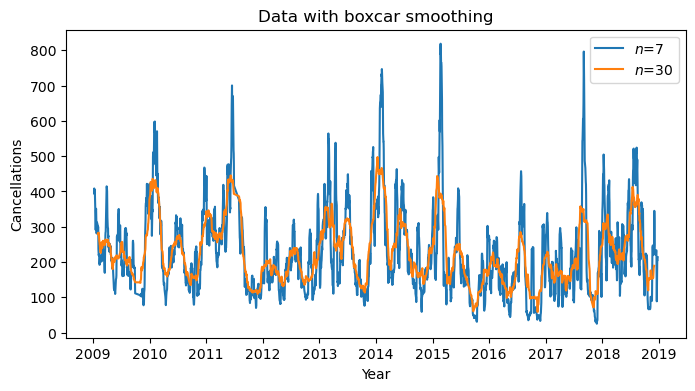

In [32]:
# Plot resulting data post smoothing
plt.figure(figsize=(8,4))
plt.ylabel("Cancellations")
plt.xlabel("Year") 
plt.plot(data.index[k:-k], box_7, label = r'$n$=7')
plt.plot(data.index[n:-n], box_30, label = r'$n$=30')
plt.title('Data with boxcar smoothing') 
plt.legend()
plt.savefig('boxcar.png')

In [33]:
# Define a store to hold the smoothed data, called temp_k
temp_k = box_30
# Define length of data enabling us to easily plot and fit polynomials to it
x_train = range(len(temp_k))

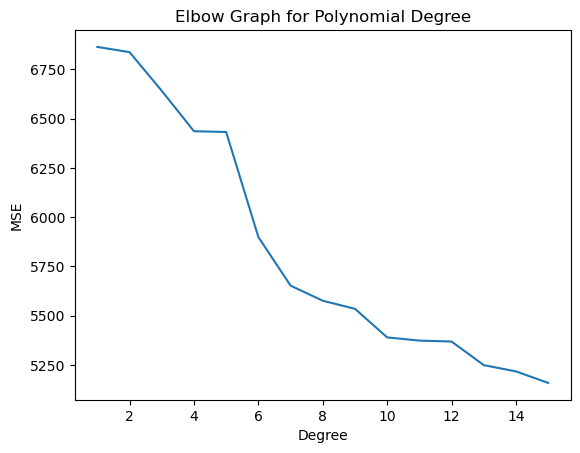

In [95]:
# Calculate the MSE for different degree polynomials, and plot the elbow graph to decide an appropriate level
MSEs = []
degrees = np.linspace(1,15, 15, endpoint=True)
for deg in degrees:
    fit = np.poly1d(np.polyfit(x_train, temp_k, deg))
    MSEs.append(mean_squared_error(temp_k, fit(x_train)))
plt.xlabel('Degree')
plt.ylabel('MSE')   
plt.title('Elbow Graph for Polynomial Degree') 
plt.plot(degrees, MSEs)
plt.savefig('elbow.png')

In [42]:
# Run polynomial regression with different degrees 
mymodel_30 = np.poly1d(np.polyfit(x_train, temp_k, 30))
mymodel_10 = np.poly1d(np.polyfit(x_train, temp_k, 10))
mymodel_5 = np.poly1d(np.polyfit(x_train, temp_k, 5))
mymodel_1 = np.poly1d(np.polyfit(x_train, temp_k, 1))

/tmp/ipykernel_57705/3391050867.py:1: RankWarning: Polyfit may be poorly conditioned
  mymodel_30 = np.poly1d(np.polyfit(x_train, temp_k, 30))


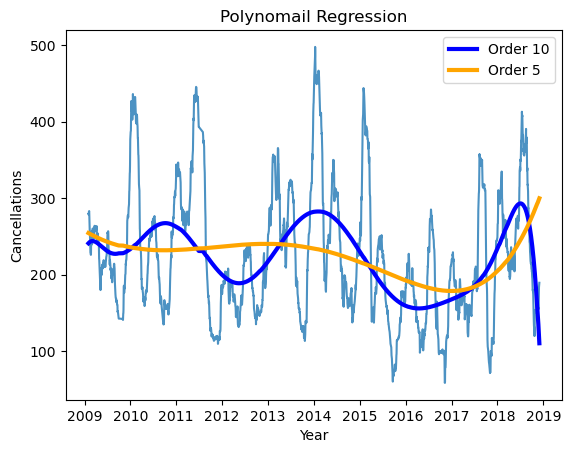

In [105]:
# Plot the polynomial regression against the raw data
plt.plot(data.index[n:-n], temp_k, alpha = 0.8)
plt.plot(data.index[n:-n],mymodel_10(x_train),'b-', linewidth = 3, label = 'Order 10')
plt.plot(data.index[n:-n],mymodel_5(x_train),'orange', linewidth = 3, label = 'Order 5')
plt.ylabel('Cancellations')
plt.xlabel('Year')
plt.title('Polynomail Regression') 
plt.legend()
plt.savefig('poly.png')

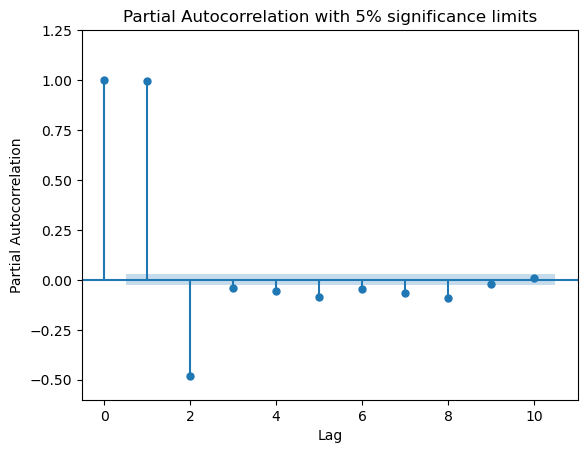

In [111]:
# Plot the partial autocorrelation to determine what level of lag the noise and data experience
sm.graphics.tsa.plot_pacf(temp_k, lags=10, method="ywm", alpha = 0.1)
plt.title('Partial Autocorrelation with 5% significance limits')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.ylim(-0.6,1.25)
plt.savefig('autocorrelation.png')

In [97]:
# Plot a multi-linear regression with the data to determine the coefficients. (could use AutoReg function)
multi_LR = linear_model.LinearRegression()

X = np.array([temp_k[1:-1], temp_k[0:-2]]).T
Y = temp_k[2:]
multi_LR.fit(X, Y)
phi_1, phi_2 = multi_LR.coef_

LinearRegression()

In [132]:
# Gaussian Noise parameters which has been finetuned to encapsulate the noise of the data
sigma = 3

# Run the autoregressive noise model 10,000 times to give an approximation to how well the data include 
MANY = []
for i in range(0,10000):
    # List to append set noise to and initialise with first 0 and 1 step autoregressive
    W = []
    W.append(np.random.normal(0, sigma))
    W.append(phi_1 * W[0])
    # loop through time steps and calculate autoregressive model using previous parameters for phis
    for i in range(0, len(Y)):
        W.append(phi_1 * W[-1] + phi_2 * W[-2] + np.random.normal(0, sigma))
    MANY.append(W)

# Define the maximum for each time step to be used as an error bar, and the mean at each time step
Wmax = np.max(MANY,axis=0)
Wmean = np.mean(MANY,axis=0)

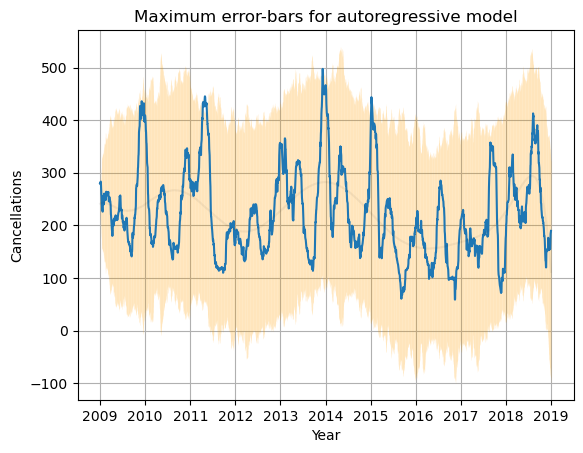

In [189]:
# plot the maximum error bars for the autoregressive model run 10000 times
plt.grid()
plt.errorbar(x_train, mymodel_10(x_train) + Wmean[:len(Y)+2], yerr = Wmax[:len(Y)+2], ecolor = 'orange', color = 'black', alpha = 0.05, elinewidth = 0.5)
plt.plot(temp_k, alpha = 1)
plt.xlabel('Year')
plt.xticks([])  
plt.xticks(ticks = np.linspace(0,3454,11), labels = ['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019'])  
plt.ylabel('Cancellations')
plt.title('Maximum error-bars for autoregressive model')
plt.savefig('errorbars.png')

In [18]:
# Has the daily proportion of flights decreased in the last 10 years?

# Define the proportion of flights cancelled per day
day_tally = day_tally.sort_index()
proportions = data / day_tally

In [19]:
# Calculate the means and variances (unbiased) for each sample
nine_ten_average = np.mean(proportions[:699], axis = 0)
nine_ten_var = np.var(proportions[:699], axis = 0, ddof = 1)
seveteen_eighteen_average = np.mean(proportions[2860:], axis = 0)
seveteen_eighteen_var = np.var(proportions[2860:], axis = 0, ddof = 1)

In [20]:
# calculate the z-statistic, and 2 sided p-value
Z = (nine_ten_average - seveteen_eighteen_average) / (np.sqrt(nine_ten_var/len(proportions[:699]) + seveteen_eighteen_var/len(proportions[2860:])))
p_value = stat.norm.sf(abs(Z))*2